In [199]:
# Imports
import pandas as pd
import glob
import numpy as np
import matplotlib
from matplotlib import image
from matplotlib import pyplot as plt
import scipy.stats
import itertools

In [200]:
# Constants
DATA_GLOB = '6G-Survey*.csv'
IMAGE_PATH = 'Map.php'
KM_PER_PX = 385/500 # Measured on the image
TEXT_TO_NUMERIC = {
    # fimilarity
    "Not familiar at all": 0,
    "Slightly familiar": 1,
    "Moderately familiar": 2,
    "Very familiar": 3,
    "Extremely familiar": 4,
    # ammount
    "Not at all": 0,
    "A little": 1,
    "A moderate amount": 2,
    "A lot": 3,
    "A great deal": 4,
    # bool
    "No": -1,
    "Maybe": 0,
    "Yes": 1,
    # agree
    "Strongly disagree": -2,
    "Somewhat disagree": -1,
    "Neutral": 0,
    "Somewhat agree": 1,
    "Strongly agree": 2,
    # time (unit is per day)
    "Never": 0,
    "Infrequently": 1 / 30,
    "Weekly": 1 / 7,
    "Daily": 1,
    "Multiple times a day": 2,
    # ages (just use average age, assume even distribution)
    "0-18": np.nan,
    "18-30": (18 + 30) / 2,
    "30-45": (30 + 45) / 2,
    "45-60": (45 + 60) / 2,
    "60+": (60 + 75) / 2,
    # gender
    # this isn't really a number but it needs to be for the
    # correlation math to work out. Ignores non male/female
    "Male": -1,
    "Female": 1,
    "Non-binary / third gender": np.nan,
    "Prefer not to say": np.nan,
}
CONCERNS = [
    "Privacy",
    "Initial cost of instillation",
    "Increased cost to use the system",
    "Reliability",
    "Dependence on internet connection",
    "Security risks",
    "Other, please specify:",
]
NUMERIC_QUESTIONS = [
    "Q12",  # How often do you use public transportation?
    "Q7",  # How familiar are you with 5G technology?
    "Q10",  # How much has 5G affected your quality of life?
    "Q11",  # How familiar are you with AI technology?
    "Q18",  # Would you prefer this over the current system?
    "Q19",  # This system would positively affect your quality of life.
    # "Q23",  # Would these considerations change any of your answers in the previous section?
    "Q25",  # Would you prefer this over the current system?
    "Q30",  # This system would positively affect your quality of life.
    "Q28",  # Select your age range.
    "Q29",  # Select your gender.
]

MULTIPLE_CHOICE_QUESTIONS = [
    
]

QUESTION_LOOKUP_TABLE = {
    "Q31": "What country are you from?",
    "Q12": "How often do you use public transportation?",
    "Q7": "How familiar are you with 5G technology?",
    "Q10": "How much has 5G affected your quality of life?",
    "Q11": "How familiar are you with AI technology?",
    "Q18": "Would you prefer this over the current system?",
    "Q19": "This system would positively affect your quality of life.",
    "Q23": "Would these considerations change any of your answers in the previous section?",
    "Q25": "Would you prefer this over the current system?",
    "Q30": "This system would positively affect your quality of life.",
    "Q28": "Select your age range.",
    "Q29": "Select your gender.",
    "Q21": "Initial concerns.",
    "Q27": "Final concerns.",
}

for question in ("Q21", "Q27"):
    for i, concern in enumerate(CONCERNS):
        MULTIPLE_CHOICE_QUESTIONS.append(f"{question}-{i}")
        QUESTION_LOOKUP_TABLE[f"{question}-{i}"] = f"{QUESTION_LOOKUP_TABLE[question][:-1]} - {concern}"

In [201]:
# Data pre-processing
data_path = glob.glob(DATA_GLOB)[0]
data = pd.read_csv(data_path)
# remove extra data at top
data = data.iloc[2:, :]

# only use responses from Taiwan
data = data[data["Q31"] == "Taiwan"]

def add_concerns_columns(data: pd.DataFrame, question: str) -> pd.DataFrame:
    concerns_idx_table = (
        data[question]
        .apply(lambda x: None if pd.isna(x) else x)
        .apply(lambda x: x.split(",") if x is not None else [])
        .apply(lambda l: {CONCERNS.index(x) for x in l})
    )

    for i in range(len(CONCERNS)):
        data[f"{question}-{i}"] = [0] * len(data)

    for row_idx, concerns_idx in concerns_idx_table.items():
        for concern_idx in concerns_idx:
            data.loc[row_idx, f"{question}-{concern_idx}"] = 1
    
    return data

# change concerns questions to be boolean values in seperate columns
data = add_concerns_columns(data, "Q21")
data = add_concerns_columns(data, "Q27")

# convert everything possible to numeric
f = lambda x: TEXT_TO_NUMERIC[x] if x in TEXT_TO_NUMERIC else x
for col in NUMERIC_QUESTIONS + MULTIPLE_CHOICE_QUESTIONS:
    data[col] = data[col].apply(f).astype(float)


data.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q21-4,Q21-5,Q21-6,Q27-0,Q27-1,Q27-2,Q27-3,Q27-4,Q27-5,Q27-6
3,2024-04-03 21:44:42,2024-04-03 21:46:43,IP Address,27.247.129.172,100,121,True,2024-04-03 21:46:44,R_4YWejBEEeYJOZqm,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-04-03 21:44:41,2024-04-03 21:48:16,IP Address,1.200.6.86,100,214,True,2024-04-03 21:48:16,R_4Ou7DA1UYexXZJL,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2024-04-03 21:56:09,2024-04-03 21:58:31,IP Address,223.143.197.140,100,142,True,2024-04-03 21:58:32,R_47jOuCIIXgIRbt8,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2024-04-03 21:59:05,2024-04-03 22:01:32,IP Address,49.216.160.26,100,146,True,2024-04-03 22:01:33,R_4wAF2UzDvlUBrc0,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2024-04-03 22:00:57,2024-04-03 22:04:53,IP Address,180.217.26.225,100,236,True,2024-04-03 22:04:54,R_4NblekhL5qc6pe9,NaN,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [202]:
# Basic Data Stats

print(f"Responses: {len(data)}")

Responses: 37


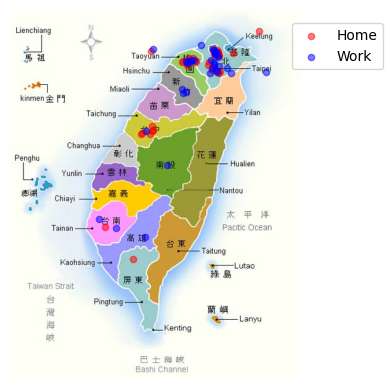

In [203]:
# Map
location_data = (
    data[["Q5_1_x", "Q5_1_y", "Q6_1_x", "Q6_1_y"]]
    .astype(float)
)
home = location_data[["Q5_1_x", "Q5_1_y"]]
work = location_data[["Q6_1_x", "Q6_1_y"]]

home_np = home.to_numpy()
work_np = work.to_numpy()
commute_distances_km = np.linalg.norm(home_np - work_np, axis=1) * KM_PER_PX

data["commute_distances_km"] = commute_distances_km

map = image.imread(IMAGE_PATH)

plt.imshow(map)
plt.scatter(home["Q5_1_x"], home["Q5_1_y"], c="red", label="Home", alpha=0.5, s=20)
plt.scatter(work["Q6_1_x"], work["Q6_1_y"], c="blue", label="Work", alpha=0.5, s=20)
# legend off to the side
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.9))
# disable axis
plt.axis("off")
plt.show()

In [204]:
# Finding correlations in the data

data_pairs = itertools.combinations(data[NUMERIC_QUESTIONS + MULTIPLE_CHOICE_QUESTIONS], 2)

# checks to see if whole column is the same value
def is_constant(s):
    a = s.to_numpy()  # s.values (pandas<0.24)
    return (a[0] == a).all()


for l, r in data_pairs:
    # ignore correlations between multiple choice questions,
    # these are better shown in a correlation matrix
    if l in MULTIPLE_CHOICE_QUESTIONS and r in MULTIPLE_CHOICE_QUESTIONS:
        continue
    
    cols = data[[l, r]].dropna(axis=0, how='any')

    # continue on constant columns
    if is_constant(cols[l]) or is_constant(cols[r]):
        continue

    stats = scipy.stats.pearsonr(cols[l], cols[r])
    if stats.pvalue < 0.05 and stats.pvalue != 0:
        print(
            f'"{QUESTION_LOOKUP_TABLE[l]}" strongly correlates with "{QUESTION_LOOKUP_TABLE[r]}":',
            end="",
        )
        print(f"  correlation={stats.statistic:.3f}, p={stats.pvalue:.4f}", end="")
        print(f"  N={len(cols)}")

"How familiar are you with 5G technology?" strongly correlates with "How familiar are you with AI technology?":  correlation=0.606, p=0.0001  N=36
"How much has 5G affected your quality of life?" strongly correlates with "How familiar are you with AI technology?":  correlation=0.574, p=0.0017  N=27
"How much has 5G affected your quality of life?" strongly correlates with "Initial concerns - Initial cost of instillation":  correlation=-0.423, p=0.0281  N=27
"How familiar are you with AI technology?" strongly correlates with "This system would positively affect your quality of life.":  correlation=0.372, p=0.0302  N=34
"How familiar are you with AI technology?" strongly correlates with "This system would positively affect your quality of life.":  correlation=0.882, p=0.0086  N=7
"How familiar are you with AI technology?" strongly correlates with "Initial concerns - Privacy":  correlation=0.387, p=0.0196  N=36
"How familiar are you with AI technology?" strongly correlates with "Initial co

Text(-0.5, 8, 'Key:\n- 0. Privacy\n- 1. Initial cost of instillation\n- 2. Increased cost to use the system\n- 3. Reliability\n- 4. Dependence on internet connection\n- 5. Security risks')

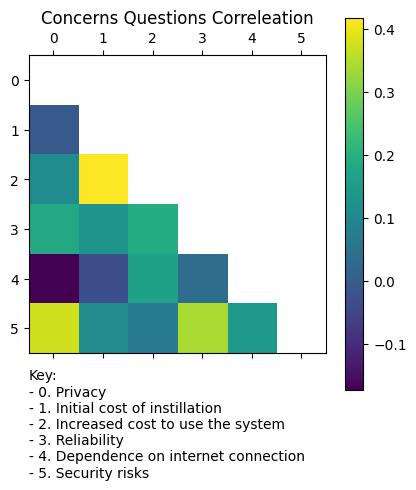

In [208]:
Q21 = data[[f"Q21-{i}" for i in range(len(CONCERNS))][:-1]]
Q21 = Q21.corr().to_numpy()

Q21[np.triu_indices(Q21.shape[0])] = np.nan

label = "Key:\n" +"\n".join([f"- {i}. {concern}" for i, concern in enumerate(CONCERNS)][:-1])

plt.matshow(Q21)
plt.colorbar()
plt.title("Concerns Questions Correleation")
plt.text(-0.5,8,label)

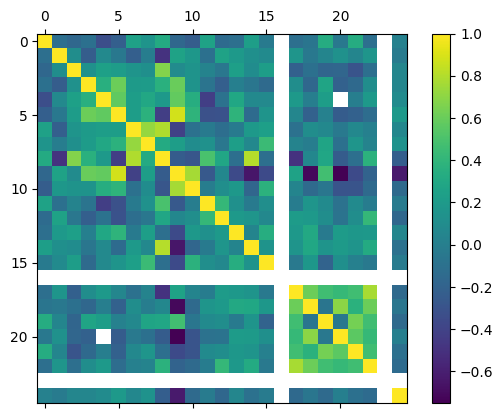

In [210]:
corr = data.select_dtypes(["number"])

corr = corr.corr()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr, interpolation="nearest")
fig.colorbar(cax)


plt.show()